# Project 3: Topic Classification using Naive Bayes

**Solution**

# Intro
---
In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively **dense** (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively **sparse** (represented as a **bag-of-words**). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

## Grading
---
- Make sure to answer every part in every question.
 - There are 7 questions and one extra credit question. 
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean and well commented, 
   - and if the functions or answers are too long.

 ## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).



In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Question 1: Examining your data
---

 1. For each of the first 5 training examples, print the text of the message along with the label (checkout newsgroups_train.target_names).

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def Q1(num_examples=5):
    ### STUDENT START ###
    """
    Input: count of examples needed, train data
    Purpose: print the first 5 texts of the message with labels
    """
    for i in range(num_examples):
        print('Example', i+1, 'is for category -', newsgroups_train.target_names[train_labels[i]])
        print('')
        print(train_data[i])
        print('=========================================================')  
    ### STUDENT END ###

Q1(5)

Example 1 is for category - comp.graphics

Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
Example 2 is for category - talk.religion.misc



Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstrating such e

### Question 2: Text representation
---

1. Transform the training data into a matrix of **word** unigram feature vectors.
  1. What is the size of the vocabulary? 
  1. What is the average number of non-zero features per example?  
  1. What is the fraction of the non-zero entries in the matrix?  
  1. What are the 0th and last feature strings (in alphabetical order)?
  - _Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors restricting to the vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. 
  1. What is the average number of non-zero features per example?
  - _Use `CountVectorization(vocabulary=...)` and its `.transform` method._
1. Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  
  1. What is the size of the vocabulary?
  - _Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._
1. Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  
  1. What is the size of the vocabulary?<br/>
  - _Use `CountVectorization(min_df=...)` and its `.fit_transform` method._
1. Now again transform the training data into a matrix of **word** unigram feature vectors. 
 1. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?
 - _Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. 

In [5]:
def Q2():
    ### STUDENT START ###
    """
    Input: train data & labels, dev data & labels
    Purpose: compare different parameters of Count Vectorizer
    """
    # question 1 without parameter
    count = CountVectorizer()
    bag = count.fit_transform(train_data)
    print('Question 1')
    print('a. Vocabulary size:',bag.shape[1])
    print('b. Average non-zero features per example: %.4f' % (bag.nnz / bag.shape[0]))
    print('c. Fraction non-zero entries: %.2f%%' % (100* bag.nnz / (bag.shape[0]*bag.shape[1])))
    print('d. 0th Feature:',count.get_feature_names()[0], 'and last feature:', count.get_feature_names()[-1])
    
    # Question 2 restricting to vocabulary
    count = CountVectorizer(vocabulary={"atheism":0, "graphics":1, "space":2, "religion":3})
    bag = count.fit_transform(train_data)
    print('-------------------------------------------')
    print('Question 2')
    print('a. Average non-zero features per example: %.4f' % (bag.nnz / bag.shape[0]))
    
    # Question 3 a matrix of character bigram and trigram feature vectors
    count = CountVectorizer(analyzer = 'char', ngram_range=(2,3))
    bag = count.fit_transform(train_data)
    print('-------------------------------------------')
    print('Question 3')
    print('a. Vocabulary size:',bag.shape[1])

     # Question 4 prune words that appear in fewer than 10 document
    count = CountVectorizer(min_df = 10)
    bag = count.fit_transform(train_data)
    print('-------------------------------------------')
    print('Question 4')
    print('a. Vocabulary size:',bag.shape[1])   
    
     # Question 5 on dev data
    count1 = CountVectorizer()
    bag_tr = count1.fit_transform(train_data)
    count2 = CountVectorizer()
    bag_dv = count2.fit_transform(dev_data)
    result = len(set(count2.get_feature_names()) - set(count1.get_feature_names()))/len(count2.get_feature_names())
    print('-------------------------------------------')
    print('Question 5')
    print('a. Fraction of words missing in training over dev total:%.4f' % (result) )
    
    ### STUDENT END ###

Q2()

Question 1
a. Vocabulary size: 26879
b. Average non-zero features per example: 96.7060
c. Fraction non-zero entries: 0.36%
d. 0th Feature: 00 and last feature: zyxel
-------------------------------------------
Question 2
a. Average non-zero features per example: 0.2684
-------------------------------------------
Question 3
a. Vocabulary size: 35478
-------------------------------------------
Question 4
a. Vocabulary size: 3064
-------------------------------------------
Question 5
a. Fraction of words missing in training over dev total:0.2479


### Question 3: Initial model evaluation
---

1. Transform the training and development data to matrices of word unigram feature vectors.
1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score. 
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.
1. Why doesn't k-Nearest Neighbors work well for this problem?
1. Why doesn't Logistic Regression work as well as Naive Bayes does?
1. What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [6]:
def Q3():
    ### STUDENT START ###
    """
    Input: train data & labels, dev data & labels
    Purpose: compare the f1 score among knn model, multinomial model and logistic regression model
    """
    
    count = CountVectorizer()
    bag = count.fit_transform(train_data)
    dev_trans = count.transform(dev_data)
    
    # produce k-nearest model
    print('k-Nearest Neighbors')
    print('')
    n_neighbor = []
    knn_f1_score = []
    for i in range(1,10,1):
        knn = KNeighborsClassifier(p=2, metric='minkowski', n_neighbors = i)
        knn.fit(bag, train_labels)
        knn_pred = knn.predict(dev_trans)
        score1 = metrics.f1_score(dev_labels, knn_pred , average = 'weighted')
        n_neighbor.append(i)
        knn_f1_score.append(score1)
    knn_df = pd.DataFrame({'n_neighbor': n_neighbor, 'knn_f1_score': knn_f1_score}).sort_values(by = ['knn_f1_score'], ascending= False).head(8)
    print(knn_df.to_string(index = False))
    print('Best n_neighbor: ', knn_df.iloc[0,0])
    print('-------------------------------')

    # produce Naive Bayes model
    print('Multinomial Naive Bayes')
    print('')
    alpha = []
    mnb_f1_score = []    
    for i in [0.0001, 0.001, 0.01, 0.05, 0.09, 0.1, 0.2, 0.5, 1.0]:
        mnb = MultinomialNB(alpha = i)
        mnb.fit(bag, train_labels)
        mnb_pred = mnb.predict(dev_trans)
        score2 = metrics.f1_score(dev_labels, mnb_pred , average = 'weighted')
        alpha.append(i)
        mnb_f1_score.append(score2)
    mnb_df = pd.DataFrame({'alpha': alpha, 'mnb_f1_score': mnb_f1_score}).sort_values(by = ['mnb_f1_score'], ascending= False).head(8)
    print(mnb_df.to_string(index = False))
    print('Best alpha value: ', mnb_df.iloc[0,0])
    print('-------------------------------')
    
    # produce Logistic Regression model
    print('Logistic Regression Model')
    print('')        
    c_value = []
    lg_f1_score = []
    ss_weights1 = []
    ss_weights2 = []
    ss_weights3 = []
    ss_weights4 = []
    for i in [0.001, 0.01, 0.05, 0.09, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 2.0]:
        lg = LogisticRegression(C = i, solver = 'liblinear', multi_class = 'auto', penalty = 'l2')
        lg.fit(bag, train_labels)
        lg_pred = lg.predict(dev_trans)
        score3 = metrics.f1_score(dev_labels, lg_pred , average = 'weighted')
        ss_weight = np.sum(lg.coef_**2)
        c_value.append(i)
        lg_f1_score.append(score3)
        ss_weights1.append(np.sum(lg.coef_[0]**2))
        ss_weights2.append(np.sum(lg.coef_[1]**2))
        ss_weights3.append(np.sum(lg.coef_[2]**2))
        ss_weights4.append(np.sum(lg.coef_[3]**2))
        
    lg_df = pd.DataFrame({'C': c_value, 'lg_f1_score': lg_f1_score, 
                          'alt.atheism': ss_weights1, 'comp.graphics': ss_weights2, 
                          'sci.space': ss_weights3, 'talk.religion.misc': ss_weights4}).sort_values(by = ['lg_f1_score'], ascending= False).head(8)
    print(lg_df.to_string(index = False))
    print('Best C value: ', lg_df.iloc[0,0])

    ### STUDENT END ###

Q3()

k-Nearest Neighbors

 n_neighbor  knn_f1_score
          7      0.450479
          8      0.446984
          6      0.446665
          9      0.436567
          5      0.428761
          3      0.408415
          4      0.403123
          2      0.380542
Best n_neighbor:  7
-------------------------------
Multinomial Naive Bayes

 alpha  mnb_f1_score
 0.100      0.790305
 0.090      0.790010
 0.200      0.787630
 0.500      0.786286
 0.050      0.785856
 1.000      0.777732
 0.010      0.775166
 0.001      0.770252
Best alpha value:  0.1
-------------------------------
Logistic Regression Model

   C  lg_f1_score  alt.atheism  comp.graphics  sci.space  talk.religion.misc
0.30     0.710085    69.299674      57.874327  67.906220           59.739934
0.50     0.708474   102.519278      83.120175  99.015796           89.026683
0.40     0.708282    86.707247      71.148747  84.216524           75.062060
0.20     0.705873    49.742190      42.749218  49.331579           42.669387
0.10     0.6

ANSWER: 
- Q5: KNN algorithm is used to classify by defining the k nearest matches in training data and then using the label of closet matches to predict. It is very susceptible to the curse of dimensionality. In a high-dimentional space, the feature space becomes very sparse with an increase of features, and that makes the closet neightbors be too far away. That makes the model not work well for this problem. 
<br>

- Q6: Normally, it depends on the dataset. For this problem, logistic regression model does not perform better than the Naive Bayes model. It could be because logistic regression models are more sensitive to outliers, and there are more outliers in this problem. Or another hypothesis is that the features (vocabularies) in this problem do not violate the independence assumption that much.
<br>

- Q7: C value is the regularization parameter in logistic regression model. Regularization is to avoid the overfitting issues by trusting the training data less. When C value is smaller, the higher the penalty to the loss function, and the sum of squared weights becomes smaller.


### Question 4: Feature exploration
---

1. Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.
1. For each topic, find the 5 features with the largest weights (not absolute value). If there are no overlaps, you can expect 20 features in total.
1. Show a 20 row (features) x 4 column (topics) table of the weights. So, for each of the features (words) found, we show their weight for all topics.
1. Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 


In [7]:
def Q4():
    ### STUDENT START ###
    """
    Input: train data & labels, dev data & labels
    Purpose: compare features w/ largest weight among 4 topics
    """
    # set up bigram feature vectors
    count = CountVectorizer(ngram_range=(2,2))
    bag = count.fit_transform(train_data)
    
    # produce a logistic regression model
    lg = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lg.fit(bag, train_labels)
    featurelist = []
    indexlist = []
    # print top 5 features for each topic
    for j in range(0,4,1):    
        print('Top 5 features for', newsgroups_train.target_names[j])
        list1 = []
        a = []
        for i in np.argsort(lg.coef_[j])[-5:][::-1]:
            list1.append(count.get_feature_names_out()[i])
            featurelist.append(count.get_feature_names_out()[i])
            indexlist.append(i)
        print(list1)
        print('------------------------------------------------')    
    df = pd.DataFrame({'feature_name': featurelist, 'feature_index': indexlist})
    
    # create a dataframe to store features and coefficients
    for i, row in df.iterrows():   
        df.loc[i,'atheism'] = lg.coef_[0][row.feature_index]
        df.loc[i,'graphics'] = lg.coef_[1][row.feature_index]
        df.loc[i,'space'] = lg.coef_[2][row.feature_index]
        df.loc[i,'religion'] = lg.coef_[3][row.feature_index]
    df = df.drop(['feature_index'], axis = 1)
    df = df.drop_duplicates()
    
    print(df.to_string(index = False))
    ### STUDENT END ###

Q4()

Top 5 features for alt.atheism
['claim that', 'cheers kent', 'was just', 'you are', 'are you']
------------------------------------------------
Top 5 features for comp.graphics
['looking for', 'in advance', 'comp graphics', 'out there', 'is there']
------------------------------------------------
Top 5 features for sci.space
['the space', 'the moon', 'sci space', 'and such', 'it was']
------------------------------------------------
Top 5 features for talk.religion.misc
['the fbi', 'cheers kent', 'ignorance is', 'but he', 'of jesus']
------------------------------------------------
 feature_name   atheism  graphics     space  religion
   claim that  0.605549 -0.199051 -0.274382 -0.140364
  cheers kent  0.555719 -0.697906 -0.663778  0.534810
     was just  0.482050 -0.131430 -0.128860 -0.227467
      you are  0.472741 -0.279893 -0.481428  0.028371
      are you  0.446954 -0.248271 -0.097170 -0.305622
  looking for -0.630341  1.108386 -0.499930 -0.571867
   in advance -0.459351  0.832569

ANSWER: 
- Many top features don't really relate to the specific topics, like was just, you are and out there. There's a room for pre-preocessing.
-  "Cheers kent" is a top feature for atheism and religion.
- I'd not expect to see "the fbi" as a top feature for religion topic.

### Question 5: Pre-processing for text
---

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

1. Produce a Logistic Regression model (with no preprocessing of text). **Note that you may need to override the "default" preprocessing with an identity function**. Evaluate and show its f1 score and size of the dictionary.
1. Produce an improved Logistic Regression model by preprocessing the text. Evaluate and show its f1 score and size of the vocabulary.  Aim for an improvement in f1 score of 0.02. **Note: this is actually very hard**.
1. How much did the improved model reduce the vocabulary size?

Notes:
* Things you can try: ** ???: Anything else we can suggest** 
 - Look at default pre-processing done.
 - Removing stop words.
 - Experiment with different ways of getting rid of apostrophe's such as replacing them with spaces or with empty strings.
  - Lower casing.
  - Including both lowercase and original case versions of a word.
  - nltk functions such as stemming.
* Train on the "transformed" training data, the data after you applied pre-processing.
* Evaluate on the transformed development data. Note that you never want to "learn" anything from the dev data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.
* The order you apply pre-processing may produce different results.


In [8]:
# stop words came up from Q4 feature exploration where I took the features with low absolute coefficients
# some common words help me get to this list of stop_words
stop_words = ['this','the','not','after','we','and','are','is','of','to','or','be','at'] 


def bt_preprocessor(text):
    text = text.lower() # lower case
    text = re.sub('\d+', 'NUM', text) # remove digit character and replace with 'NUM'
    text = re.sub('[^(a-zNUM)]',' ', text) # remove non alphabetic character
    
    text = ' '.join([word for word in text.split() if len(word) > 1]) # remove one letter word
    text = ' '.join([word for word in text.split() if word not in stop_words]) # remove stop words    
    text = ' '.join([x[:5] for x in text.split()]) # only take first 5 characters
   
    return text

In [9]:
def Q5():
    ### STUDENT START ###
    """
    Input: preprocessor data, train and dev data
    Purpose: evaluate f1 scores between no pre-processing data and pre-processing data
    """
    
    # produce a logistic regression model with no pre-processing data
    count1 = CountVectorizer(lowercase = False, preprocessor = (lambda x:x)) 
    bag = count1.fit_transform(train_data)
    print('Vocabulary size without pre-processing:', bag.shape[1])

    lg = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lg.fit(bag, train_labels)
    dev_pred = lg.predict(count1.transform(dev_data))
    score1 = metrics.f1_score(dev_labels, dev_pred, average = 'weighted')
    print('F1 score for no pre-processing data: ', score1)
    
    # produce a logistic regression model with pre-processing data
    count2 = CountVectorizer(preprocessor = bt_preprocessor) 
    bag2 = count2.fit_transform(train_data)
    print('Vocabulary size with pre-processing:', bag2.shape[1])

    lg = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    lg.fit(bag2, train_labels)
    dev_pred2 = lg.predict(count2.transform(dev_data))
    score2 = metrics.f1_score(dev_labels, dev_pred2, average = 'weighted')
    print('F1 score for pre-processing data: ', score2)    
    ### STUDENT END ###

Q5()

Vocabulary size without pre-processing: 33291
F1 score for no pre-processing data:  0.7069109185493502
Vocabulary size with pre-processing: 15046
F1 score for pre-processing data:  0.7331790502262706


ANSWER: the pre-processing function removes more than half of the vocabularies.

### Question 6: L1 and L2 regularization
---

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, **L1 regularization drives many of the weights to 0, effectively removing unimportant features**. For this reason, we can use it as a way to do "feature selection".

1. For several L1 regularization strengths ...
  1. Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.
  1. Produce a new Logistic Regression model using the reduced vocabulary . For this new model, use an **L2** regularization strength of 0.5.  
  1. Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.
1. Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.
1. How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* No need to apply pre-processing from question 5.
* Train on the transformed (i.e. CountVectorizer) training data.
* Evaluate on the transformed development data (using the CountVectorizer instance you trained on the training data).
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).
* (solver="liblinear" might be needed for it not to crash)

 C_value  l1_vocab_ct  l1_f1_score  l2_vocab_ct  l2_f1_score
   0.001        26879     0.244928            3     0.333569
   0.010        26879     0.420515           17     0.467828
   0.030        26879     0.516266           67     0.604553
   0.050        26879     0.576255          123     0.643811
   0.100        26879     0.645301          212     0.680049
   0.300        26879     0.691147          524     0.672076
   0.500        26879     0.688016          746     0.659186
   1.000        26879     0.689041         1169     0.682936
  10.000        26879     0.669328         3489     0.686079
  50.000        26879     0.637940         6074     0.680192
 100.000        26879     0.648895         7689     0.688196
1000.000        26879     0.618599        24755     0.703506


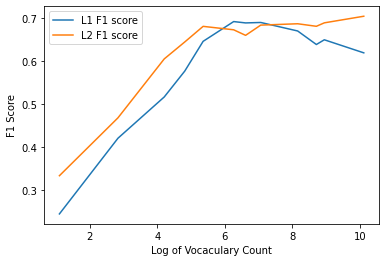

In [10]:
def Q6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    """
    Input: regularization value, train and dev data
    Purpose: Understand how regularization value impacts vocabulary size and the f1 scores
    """
    
    # set up required lists
    cvalue = [0.001, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5, 1, 10, 50, 100, 1000]
    l1score = []
    vocab1 = []
    l2score = []
    vocab2 = []
    vocab_log = []

    for k in cvalue:
        # set up l1 logistic regression model with different c values
        count1 = CountVectorizer() 
        bag1 = count1.fit_transform(train_data)    
        lg1 = LogisticRegression(C=k, tol = 0.015, solver="liblinear",  penalty = 'l1')
        lg1.fit(bag1, train_labels)
        dev_pred = lg1.predict(count1.transform(dev_data))
        l1score.append(metrics.f1_score(dev_labels, dev_pred, average = 'weighted'))
        vocab1.append(bag1.shape[1])
        
        # extract features index with coefficients not equal to zero
        test = pd.DataFrame(lg1.coef_)
        test.loc['Total'] = pd.Series(test.sum(), index = test.columns)
        test = test.T
        a = test.loc[test['Total'] != 0,:]

        key_list = list(count1.vocabulary_.keys())
        val_list = list(count1.vocabulary_.values())
        dict_test = []
        for i, row in a.iterrows():
            position = val_list.index(i)
            dict_test.append(str(key_list[position]))  
            
        # set up l2 logistic regression model with reduced vocab list
        count2 = CountVectorizer(vocabulary= dict_test)
        bag2 = count2.fit_transform(train_data)
        vocab2.append(bag2.shape[1])
        vocab_log.append(np.log(bag2.shape[1]))

        lg2 = LogisticRegression(C=0.5,tol = 0.015, solver="liblinear", penalty = 'l2')
        lg2.fit(bag2, train_labels)
        dev_pred2 = lg2.predict(count2.transform(dev_data))
        l2score.append(metrics.f1_score(dev_labels, dev_pred2, average = 'weighted'))
        
    # create a dataframe to store c value, vocabulary counts and f1 scores
    df_q = pd.DataFrame({'C_value': cvalue, 'l1_vocab_ct': vocab1, 'l1_f1_score':l1score,
                        'l2_vocab_ct': vocab2, 'l2_f1_score':l2score})
    print(df_q.to_string(index = False))
    
    # Show a plot of f1 score vs. log vocabulary size
    plt.plot(vocab_log, l1score, label = 'L1 F1 score' )
    plt.plot(vocab_log, l2score, label = 'L2 F1 score' )
    plt.xlabel('Log of Vocaculary Count')
    plt.ylabel('F1 Score')
    plt.legend()
    ### STUDENT END ###

Q6()

ANSWER: It depends on the C value - regularization parameter. When it's below 0.1, the models based on reduced vocabularies perform better than models based on the full vocabulary. Between 0.3 and 1, it's the other way around. Generally, the models with reduced vocabularies perform better.

### Question 7: TfIdf
---
As you may recall [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) stands for *term frequency inverse document frequency* and is a way to assign a weight to each word or token signifying their importance for a document in a corpus (a collection of documents).

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

1. How is `TfidfVectorizer` different than `CountVectorizer`?
1. Show the 3 documents with highest R ratio, where ...
  - $R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$
1. Explain what the R ratio describes.
1. What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [11]:
def Q7():
    ### STUDENT START ###
    """
    Input: train and dev data
    Purpose: Understand Tfid vectorizer
    """
    
    # produce a logistic regression model with tfid vectorizer
    tfidcount = TfidfVectorizer() 
    bag = tfidcount.fit_transform(train_data)
    lg2 = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty = 'l2')
    lg2.fit(bag, train_labels)

    dev_pred = lg2.predict(tfidcount.transform(dev_data))
    print('f1 score for the model: ', metrics.f1_score(dev_labels, dev_pred, average = 'weighted'))
    
    # create a dataframe to store prediction probability and create R-value
    df = pd.DataFrame(lg2.predict_proba(tfidcount.transform(dev_data)))
    for index, row in df.iterrows():
        df.at[index, 'Rvalue'] = row.max()/row[int(dev_labels[int(index)])]
    
    # extract top 3 documents and print out
    top3 = df.nlargest(3,['Rvalue'])
    for i, row in top3.iterrows():
        print('Top document with highest R ratio')
        print('Correct Topic: ', dev_labels[i], 'Predicted topic: ', dev_pred[i])
        print('R-value: ', row['Rvalue'])
        print('----------------- document content: ----------------------------')
        print(dev_data[i])
        print('================================================================')   
    
    ### STUDENT END ###

Q7()

f1 score for the model:  0.7597662427853104
Top document with highest R ratio
Correct Topic:  3 Predicted topic:  1
R-value:  929.3578626925238
----------------- document content: ----------------------------
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy cente

ANSWER: 
- Q1: CountVectorizer counts the frequency of a word in documents. Because it's based on word frequency, the model might miss some rare but critical words that do not apprear often. It also does not identify the relationships between words such as linguistic similarity between words. On the other hand, TfidVectorizer is based on the frequency of a word in the corpus but it also provides a numerical representation of how important a word is for statistical analysis.
<br>

- Q3: The R ratio considers the maximum probability and the probability of correct label. If the model predicts correctly, the R ratio would be zero. If the model assigns a topic with a low probability and it turns out to be correct, the R ratio becomes large. Basically, R ratio indicates how far the model is in predicting the true label.
<br>

- Q4: For the first two documents, it is clear that the contents are related to the religion topic with "Mormon" mentioned. However, there are several computer related terms, e.g., ftp, ASCII and dba. That might make the model think they are related to the graphic variable. One fix I can think of is to increase the frequency of topic-specific keywards, like "Mormon", "lone", "seconds" and "bullet" in this case.

### Question 8 EXTRA CREDIT:
---
Produce a Logistic Regression model to implement your suggestion from Part 7.

In [12]:
def extra_preprop(text):
    text = text.lower() # lower case
    text = text.replace('mormon','mormon mormon mormon mormon mormon mormon mormon mormon mormon mormon' )
    text = text.replace('bullets', 'bullets bullets bullets bullets bullets bullets bullets bullets')
    text = text.replace('lone', 'lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone lone')
    text = text.replace('seconds', 'seconds seconds seconds seconds seconds')
    
    return text
    

In [13]:
def Q7():
    ### STUDENT START ###
    """
    Input: train and dev data
    Purpose: Understand Tfid vectorizer
    """
    
    # produce a logistic regression model with tfid vectorizer
    tfidcount = TfidfVectorizer(preprocessor = extra_preprop) 
    bag = tfidcount.fit_transform(train_data)
    lg2 = LogisticRegression(C=100, solver="liblinear", multi_class="auto", penalty = 'l2')
    lg2.fit(bag, train_labels)

    dev_pred = lg2.predict(tfidcount.transform(dev_data))
    print('f1 score for the model: ', metrics.f1_score(dev_labels, dev_pred, average = 'weighted'))
    
    # create a dataframe to store prediction probability and create R-value
    df = pd.DataFrame(lg2.predict_proba(tfidcount.transform(dev_data)))
    for index, row in df.iterrows():
        df.at[index, 'Rvalue'] = row.max()/row[int(dev_labels[int(index)])]
    
    # extract top 3 documents and print out
    verify = df.iloc[[215, 665, 607],:]
    for i, row in verify.iterrows():
        print('Top document with highest R ratio')
        print('Correct Topic: ', dev_labels[i], 'Predicted topic: ', dev_pred[i])
        print('R-value: ', row['Rvalue'])
        print('----------------- document content: ----------------------------')
        print(dev_data[i])
        print('================================================================')   
    
    ### STUDENT END ###

Q7()

f1 score for the model:  0.7728795147063162
Top document with highest R ratio
Correct Topic:  3 Predicted topic:  3
R-value:  1.0
----------------- document content: ----------------------------
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), bu

The fix increases the f1 score and helps to correctly predict the labels of all three documents.